## Key takeaways for this chapter

### Meshgrid
Whenever you put the outcome of some operation between the elements of a meshgrid, like `vx*vy`, (or in general a 2d array) in a Pandas `DataFrame` the index is taken by the `y` component whereas the columns are taken by the `x` component.
This might be a bit confusing as to get the marginal of `x` one has to sum over rows `axis=0`, and over columns `axis=1` for `y` marginal.

### Approach
In a nutshell this is the approach we followed for the exercises:
* Get prior for each of the elements we are going to compare.
* Compute the joint probability of the elements
* Compute the likelihood based on some operation between the ranges (index, columns) of the elements. (comparison for heights, logit for chess exercise)
* Do a regular update
* Compute the marginal of X by summing over rows (axis=0)
* Compute the marginal of Y by summing over columns (axis=1)
* Compute the mean of each marginal

In the exercises we used normal distributions for priors and, I found striking to use different ranges for them as in my mind we should compare over the same set of heights. Afterwards, thinking more carefully, given that one performs some operation over the ranges of the distributions to compute the likelihood, there might not be a great difference in the outcome.


## How cartesian products work

In [55]:
## How cartesian products work
import numpy as np
import pandas as pd
x = [10, 20, 30]
y = [40, 50]
vx, vy = np.meshgrid(x, y)
df = pd.DataFrame(vy + vx, index=y, columns=x)
df.sum(axis=0)  # [110, 130, 150]
df.sum(axis=1)  # [180, 210]

40    180
50    210
dtype: int64

## Exercise 1
### Part A: How tall is A

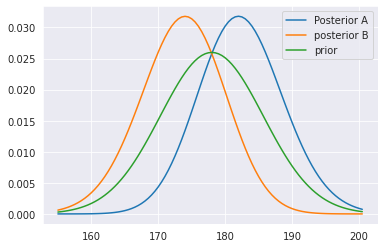

In [61]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import decorate

def plot_cmesh(df, cmap='Blues'):
	"""Plot a joint distribution with a color mesh."""
	vmax = df.to_numpy().max() * 1.1
	plt.pcolormesh(df.columns, df.index, df,
				   cmap=cmap,
				   vmax=vmax,
				   shading='nearest')
	plt.colorbar()

	decorate(xlabel='A height in cm',
			 ylabel='B height in cm')

# Create a normal distribution with
mu, std = 178, 7.7
hs = np.arange(mu-round(std*3), mu+round(std*3), .5)
prior = norm(178, 7.7).pdf(hs)
prior /= prior.sum()

# Create a joint probability to compare two persons
vx, vy = np.meshgrid(prior, prior)
joint = pd.DataFrame(vx*vy, index=hs, columns=hs)
# plot_cmesh(joint)

# Create the likelihood df for A > B
vx, vy = np.meshgrid(hs, hs)
likes = pd.DataFrame(vx > vy, index=hs, columns=hs).astype(int)

# Compute the posterior
posterior = joint.values * likes.values
posterior /= posterior.sum()
posterior = pd.DataFrame(posterior, index=hs, columns=hs)
# plot_cmesh(posterior)

# get the marginals
marginal_A = posterior.values.sum(axis=0)
marginal_B = posterior.values.sum(axis=1)
fig, ax = plt.subplots()
sns.lineplot(x=hs, y=marginal_A, ax=ax, label="Posterior A")
sns.lineplot(x=hs, y=marginal_B, ax=ax, label="posterior B")
sns.lineplot(x=hs, y=prior, ax=ax, label="prior")

# get the conditional posterior for A = 170
a170 = posterior[170].values
# sns.lineplot(x=hs, y=a170);
np.sum(hs * a170 / a170.sum())  # mean

# get the conditional posterior for B = 180
b180 = posterior.loc[180, :].values
# sns.lineplot(x=hs, y=b180);
# np.sum(hs * b180 / b180.sum())


### Part B, extending to women

<AxesSubplot:>

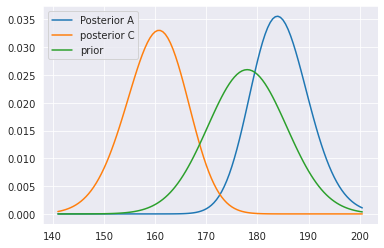

In [62]:
mu_m, std_m = 178, 7.7
mu_w, std_w = 163, 7.3
hs = np.arange(mu_w-round(std_w*3), mu_m+round(std_m*3), .5)
prior = norm(178, 7.7).pdf(hs)
prior /= prior.sum()

# Create a joint probability to compare two persons
vx, vy = np.meshgrid(prior, prior)
joint = pd.DataFrame(vx*vy, index=hs, columns=hs)
# plot_cmesh(joint)

# Create the likelihood df for A > B
vx, vy = np.meshgrid(hs, hs)
likes = pd.DataFrame(vx > vy, index=hs, columns=hs).astype(int)

# Compute the posterior
posterior = joint.values * likes.values
posterior /= posterior.sum()
posterior = pd.DataFrame(posterior, index=hs, columns=hs)
# plot_cmesh(posterior)

# get the marginal
marginal_A = posterior.values.sum(axis=0)

# Get the prior for the woman
prior_woman = norm(mu_w, std_w).pdf(hs)
prior_woman /= prior_woman.sum()

# get the joint probabilty
vx, vy = np.meshgrid(marginal_A, prior_woman)
joint = pd.DataFrame(vx * vy, index=hs, columns=hs)
# plot_cmesh(joint)

# create the likelihood for A - C >= 15
vx, vy = np.meshgrid(hs, hs)
likes = pd.DataFrame(vx - vy >= 15, index=hs, columns=hs)
# plot_cmesh(likes)

# compute posterior
posterior = joint.values * likes.values
posterior /= posterior.sum()
posterior = pd.DataFrame(posterior, index=hs, columns=hs)
# plot_cmesh(posterior)

# get marginals for posterior distributions
marginal_A = posterior.values.sum(axis=0)
marginal_C = posterior.values.sum(axis=1)

fig, ax = plt.subplots()
sns.lineplot(x=hs, y=marginal_A, ax=ax, label="Posterior A")
sns.lineplot(x=hs, y=marginal_C, ax=ax, label="posterior C")
sns.lineplot(x=hs, y=prior, ax=ax, label="prior")

# Simulating a Tournament of Chess
More insights inside the class, but in a nutshel, we simulate a bunch of matches between two persons on a tournament. This allowed me to realise first hand zero-sum games and how they can become positive sum games over time (but still being zero-sum for individual matches)

In [2]:
from py_scripts.tournament import Tournament

record_tape = Tournament().run()
record_tape

,prob_a,prob_b,match_outcome,pre_match_score_a,pre_match_score_b,post_match_score_a,post_match_score_b,post_training_score_a,post_training_score_b,total_points
0,0.5,0.5,0,100,100,116.0,100,117.922651,100,217.922651
1,0.52577,0.47423,0.5,117.922651,100,118.747288,100,117.858411,101.365913,219.224324
2,0.523717,0.476283,0.5,117.858411,101.365913,118.617348,100.606975,118.541404,100.363351,218.904755
3,0.526136,0.473864,0,118.541404,100.363351,135.377771,100,137.820152,100,237.820152
4,0.554214,0.445786,1,137.820152,100,123.554988,114.265164,124.451279,115.596113,240.047392
...,...,...,...,...,...,...,...,...,...,...
995,0.95607,0.04393,1,1374.773793,839.681754,1373.368038,841.087509,1374.029015,844.203616,2218.232631
996,0.954779,0.045221,1,1374.029015,844.203616,1372.581946,845.650685,1372.531962,846.57332,2219.105282
997,0.953808,0.046192,1,1372.531962,846.57332,1371.053826,848.051457,1370.966429,850.376545,2221.342974
998,0.952427,0.047573,1,1370.966429,850.376545,1369.444105,851.898869,1369.596726,853.817376,2223.414101


<AxesSubplot:>

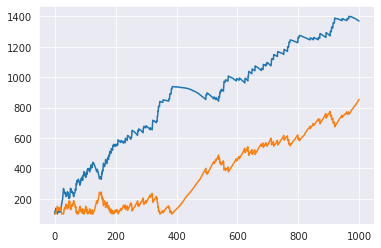

In [3]:
record_tape.pre_match_score_a.plot(label='a')
record_tape.pre_match_score_b.plot(label='b')

# Chess Exercise

In [ ]:
from typing import Union

score_range = np.arange(1300, 1900, 10)

# Create priors
player_a_prior = norm(1600, 100).pdf(score_range)
player_b_prior = norm(1800, 100).pdf(score_range)

# get joint probability
vx, vy = np.meshgrid(player_a_prior, player_b_prior)

joint = pd.DataFrame(
	vx * vy,
	index=score_range,
	columns=score_range
)

def logit(diff_of_scores: Union[int, np.ndarray], discriminant: int = 400) -> float:
	"""
	Compute the probability of winning based on the difference of scores and a logistic curve.

	A positive difference would mean the second player to be superior and a negative one
	the other way round.
	"""
	exp = -(diff_of_scores / discriminant)
	return 1 / (1 + (10**exp))

vx, vy = np.meshgrid(score_range, score_range)
likes = logit(vy - vx)

# plot_joint(pd.DataFrame(likes, index=score_range, columns=score_range))

posterior = joint * likes
posterior /= posterior.sum().sum()

post_a = posterior.sum(axis=0)
post_b = posterior.sum(axis=1)

(
	np.sum(post_a * score_range),
	np.sum(post_b * score_range)
)